* Master DAC, BDLE, 2021 
* Author: Mohamed-Amine Baazizi
* Affiliation: LIP6 - Faculté des Sciences - Sorbonne Université
* Email: mohamed-amine.baazizi@lip6.fr


 **Binôme :**

- **Inas KACI**
- **Célina KHALFAT**

# Decision Tree in Spark ML



```
# This is formatted as code
```

## Préparation

Vérifier que des ressources de calcul sont allouées à votre notebook est connecté (cf RAM  de disque indiqués en haut à droite) . Sinon cliquer sur le bouton connecter pour obtenir des ressources.




Pour accéder directement aux fichiers stockées sur votre google drive. Renseigner le code d'authentification lorsqu'il est demandé

Ajuster le nom de votre dossier : MyDrive/ens/bdle/dir. **Remplacer dir **

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

drive_dir = "/content/drive/MyDrive/ens/bdle/DM2"
os.makedirs(drive_dir, exist_ok=True)
os.listdir(drive_dir)

Mounted at /content/drive


['housing.csv']

Installer pyspark et findspark :


In [ ]:
!pip install -q pyspark
!pip install -q findspark

     |████████████████████████████████| 281.3 MB 8.5 kB/s 
     |████████████████████████████████| 198 kB 60.9 MB/s 


Démarrer la session spark

In [ ]:
import os
# !find /usr/local -name "pyspark"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"
os.environ["JAVA_HOME"] = "/usr"

In [ ]:
# Principaux import
import findspark
from pyspark.sql import SparkSession 
from pyspark import SparkConf  

# pour les dataframe et udf
from pyspark.sql import *  
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

# pour le chronomètre
import time

#pour les dataframe de pandas
import pandas as pd

# initialise les variables d'environnement pour spark
findspark.init()

# Démarrage session spark 
# --------------------------
def demarrer_spark():
  local = "local[*]"
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory")
  
  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (4 coeurs)
  spark.conf.set("spark.sql.shuffle.partitions","4")    
  print("session démarrée, son id est ", sc.applicationId)
  return spark
spark = demarrer_spark()

session démarrée, son id est  local-1637178063518


In [ ]:
# on utilise 8 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées :  8


## Chargement des données

Le dataset que nous allons utilisée est celui sur les maisons aux Etats-Unis  : USA Housing.

### Premier essai du chargement des données

Nous téléchargeons les données à l'aide de spark.

In [ ]:
housing_spark =  spark.read\
            .format("csv").option("header", "true")\
            .option("inferSchema", "true")\
            .load(drive_dir +"/housing.csv")
housing_spark.printSchema()

root
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: string (nullable = true)
 |-- type: string (nullable = true)
 |-- sqfeet: string (nullable = true)
 |-- beds: string (nullable = true)
 |-- baths: string (nullable = true)
 |-- cats_allowed: string (nullable = true)
 |-- dogs_allowed: string (nullable = true)
 |-- smoking_allowed: string (nullable = true)
 |-- wheelchair_access: string (nullable = true)
 |-- electric_vehicle_charge: integer (nullable = true)
 |-- comes_furnished: string (nullable = true)
 |-- laundry_options: string (nullable = true)
 |-- parking_options: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- state: string (nullable = true)



In [ ]:
take_id = housing_spark['id']=="7047757846"
housing_id_spark = housing_spark[take_id]
housing_id_spark.show()

+----------+--------------------+------------+--------------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------+
|        id|                 url|      region|          region_url|price|     type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|parking_options|           image_url|         description|                 lat|                long|         state|
+----------+--------------------+------------+--------------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------+
|

On remarque que les valeurs ne correspondent pas aux colonnes : 
- les latitudes et longitudes sont des bouts de phrases
- l'état est une somme par mois

L'analyse suivante permet également de montrer que les valeurs des états sont incohérents : 

In [ ]:
housing_spark.select('state').distinct().count()

4442

On compte 4442 états différents alors qu'il n'existe que 50 états aux États Unis...

Il existe également des tuples où les id sont des chaînes de caractères : 

In [ ]:
housing_spark.select('*').filter ( col("id").rlike("[A-z]")).distinct().show()

+--------------------+--------------------+--------------------+----------+---------+--------------+-------------+----------------+--------------------+------------+--------------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---------------+-----------+--------+----+-----+
|                  id|                 url|              region|region_url|    price|          type|       sqfeet|            beds|               baths|cats_allowed|        dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|parking_options|      image_url|description|     lat|long|state|
+--------------------+--------------------+--------------------+----------+---------+--------------+-------------+----------------+--------------------+------------+--------------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---------------+----------

**Mini-conclusion** : la manière dont les données sont chargées "casse" la structure initiale des données.

### Chargement des données 

Nous allons dans un premier temps lire le fichier à l'aide de pandas puis créer une DataFrame spark.

In [ ]:
right_schema = StructType([ StructField("id",LongType(), True),  #Integer pas assez grand
                      StructField("url",StringType(), True),
                      StructField("region",StringType(), True),
                      StructField("region_url",StringType(), True),
                      StructField("price",LongType(), True),
                      StructField("type",StringType(), True),
                      StructField("sqfeet",IntegerType(), True),
                      StructField("beds",IntegerType(), True),
                      StructField("baths",DoubleType(), True),
                      StructField("cats_allowed",IntegerType(), True),
                      StructField("dogs_allowed",IntegerType(), True),
                      StructField("smoking_allowed",IntegerType(), True),
                      StructField("wheelchair_access",IntegerType(), True),
                      StructField("electric_vehicle_charge",IntegerType(), True),
                      StructField("comes_furnished",IntegerType(), True),
                      StructField("laundry_options",StringType(), True),
                      StructField("parking_options",StringType(), True),
                      StructField("image_url",StringType(), True),
                      StructField("description",StringType(), True),
                      StructField("lat",DoubleType(), True),
                      StructField("long",DoubleType(), True),
                      StructField("state",StringType(), True)
])

In [ ]:
housing_pd= pd.read_csv(drive_dir + "/housing.csv")
housing=spark.createDataFrame(housing_pd , schema=right_schema) 

In [ ]:
#Permet de remplacer les NaN par des null
housing=housing.replace(float('NaN'), None)
housing=housing.replace('NaN', None)

In [ ]:
take_id = housing['id']=="7047757846"
housing_id = housing[take_id]
housing_id.show()

+----------+--------------------+------------+--------------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+--------------------+--------------------+-------+-------------------+-----+
|        id|                 url|      region|          region_url|price|     type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|parking_options|           image_url|         description|    lat|               long|state|
+----------+--------------------+------------+--------------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+--------------------+--------------------+-------+-------------------+-----+
|7047757846|https://reno.crai...|reno / tahoe|https://reno.crai...| 16

Avec le même id (7047757846) que lors du test précédent, les valeurs de la latitude, longitude et de l'état sont cohérentes et le nombre d'état différents est plus réaliste.

In [ ]:
housing.select('state').distinct().count()

51

Cependant, 3 tuples sont supprimés lors de ce chargement. Ces 3 tuples correspondent aux tuples dont les id étaient des chaînes de caractères : 

In [ ]:
housing.select('*').filter ( col("id").rlike("[A-z]")).distinct().show()

+---+---+------+----------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---------+-----------+---+----+-----+
| id|url|region|region_url|price|type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|parking_options|image_url|description|lat|long|state|
+---+---+------+----------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---------+-----------+---+----+-----+
+---+---+------+----------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---------+-----------+---+----+-----+



**Conclusion :** Les données sont bien mieux structurées en les chargeant de cette manière.

La DataFrame de Spark que nous allons utilisé est donc **housing**.

## Analyse des données

Nous allons maintenant analyser les données plus en détail. Nous allons nous intéresser : 
- à des statistiques basiques telles que la moyenne, l'écart-type, le min et le max
- au taux de valeurs manquantes
- au nombre de valeurs distincts dans chaque colonne (pour savoir si l'information varie trop ou pas assez)
- aux outliers



In [ ]:
housing.show()

+----------+--------------------+------------+--------------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+-------------------+-----+
|        id|                 url|      region|          region_url|price|     type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|   parking_options|           image_url|         description|    lat|               long|state|
+----------+--------------------+------------+--------------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+-------------------+-----+
|7049044568|https://reno.crai...|reno / tahoe|https://reno.cr

In [ ]:
print("Il y a", housing.select("*").count(),"tuples.")

Il y a 384977 tuples.


In [ ]:
NB_TUPLES = 384977

- les différentes fonctions qui seront utilisées

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyspark.sql.functions as f

In [ ]:
@udf('float')
def pourcentage(n):
  return (n/NB_TUPLES)*100

In [ ]:
def outliers_normale (col) :
  bounds = {
    c: dict(
        zip(["q1", "q3"], col.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in col.columns
  }
  print('bounds : ', bounds)
  c = col.columns[0]
  q1 = bounds[c]['q1']
  q3 = bounds[c]['q3']
  interq = q3-q1
  min = q1 - 1.5*interq
  max = q3 + 1.5*interq
  print('min : ', min)
  print('max : ', max)
  return col.select(
    "*",
    *[
        f.when(
            f.col(c).between(min, max),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in col.columns
    ]
    )

In [ ]:
def outliers_autres (col) :
  bounds = {
    c: dict(
        zip(["q01", "q99"], col.approxQuantile(c, [0.01, 0.99], 0))
    )
    for c in col.columns
  }
  print('bounds : ', bounds)
  return col.select(
    "*",
    *[
        f.when(
            f.col(c).between(bounds[c]['q01'], bounds[c]['q99']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in col.columns
    ]
    )

Les outliers ne sont pas détecter de la même façon si une distribution est normale ou non.

 - Si la distribution est **normale** :

 Soit IQR, l'écart entre le quartile q1 (25%) et q3 (75%), une valeur est considéré comme un outlier si elle est inférieur à q1 - 1.5*IQR ou si elle est supérieur à q3 + 1.5*IQR.

 - Si c'est une **autre distribution** :     

 On peut s'intéresser aux centiles, une valeur est considéré comme un outilier si elle est inférieur à 1% centile ou si elle est supérieur à 99% centile.


### Analyse des id

In [ ]:
housing.select('*').filter ( col("id").rlike("[0-9]")).distinct().count()

384977

Tous les id de la base de données sont distincts et bien des chiffres.

### Analyse sur les attributs à valeur booléenne

#### cats_allowed

In [ ]:
cats_allowed_distinct = housing.select('cats_allowed').groupby('cats_allowed').count().alias('count').withColumn("pourcentage",pourcentage("count"))
cats_allowed_distinct.show()

+------------+------+-----------+
|cats_allowed| count|pourcentage|
+------------+------+-----------+
|           1|279836|   72.68902|
|           0|105141|  27.310982|
+------------+------+-----------+



#### dogs_allowed

In [ ]:
dogs_allowed_distinct = housing.select('dogs_allowed').groupby('dogs_allowed').count().alias('count').withColumn("pourcentage",pourcentage("count"))
dogs_allowed_distinct.show()

+------------+------+-----------+
|dogs_allowed| count|pourcentage|
+------------+------+-----------+
|           1|272532|   70.79176|
|           0|112445|  29.208239|
+------------+------+-----------+



#### smoking_allowed

In [ ]:
smoking_allowed_distinct = housing.select('smoking_allowed').groupby('smoking_allowed').count().alias('count').withColumn("pourcentage",pourcentage("count"))
smoking_allowed_distinct.show() 

+---------------+------+-----------+
|smoking_allowed| count|pourcentage|
+---------------+------+-----------+
|              1|281715|    73.1771|
|              0|103262|    26.8229|
+---------------+------+-----------+



#### wheelchair_access

In [ ]:
wheelchair_access_distinct = housing.select('wheelchair_access').groupby('wheelchair_access').count().alias('count').withColumn("pourcentage",pourcentage("count"))
wheelchair_access_distinct.show()

+-----------------+------+-----------+
|wheelchair_access| count|pourcentage|
+-----------------+------+-----------+
|                1| 31611|    8.21114|
|                0|353366|   91.78886|
+-----------------+------+-----------+



#### electric_vehicle_charge

In [ ]:
electric_vehicle_charge_distinct = housing.select('electric_vehicle_charge').groupby('electric_vehicle_charge').count().alias('count').withColumn("pourcentage",pourcentage("count"))
electric_vehicle_charge_distinct.show()

+-----------------------+------+-----------+
|electric_vehicle_charge| count|pourcentage|
+-----------------------+------+-----------+
|                      1|  4955|  1.2870898|
|                      0|380022|   98.71291|
+-----------------------+------+-----------+



#### comes_furnished

In [ ]:
comes_furnished_distinct = housing.select('comes_furnished').groupby('comes_furnished').count().alias('count').withColumn("pourcentage",pourcentage("count"))
comes_furnished_distinct.show()

+---------------+------+-----------+
|comes_furnished| count|pourcentage|
+---------------+------+-----------+
|              1| 18528|   4.812755|
|              0|366449|   95.18725|
+---------------+------+-----------+



Pour les attributs à valeur booléenne, on remarque que les données sont propres : 

*   Les deux labels présents sont 0 et 1 
*   La somme des valeurs est égale à 384977 soit le nombre de tuple total





### Analyse sur les attributs à valeur catégorielle

#### laundry_options

In [ ]:
laundry_options_distinct = housing.select('laundry_options').groupby('laundry_options').count().alias('count').withColumn("pourcentage",pourcentage("count")).orderBy('count')
laundry_options_distinct.show()

+------------------+------+-----------+
|   laundry_options| count|pourcentage|
+------------------+------+-----------+
|no laundry on site|  3624| 0.94135493|
|   laundry in bldg| 36103|   9.377963|
|   laundry on site| 58873|  15.292602|
|       w/d hookups| 75568|  19.629225|
|              null| 79026|   20.52746|
|       w/d in unit|131783|  34.231396|
+------------------+------+-----------+



#### type

In [ ]:
type_distinct = housing.select('type').groupby('type').count().alias('count').withColumn("pourcentage",pourcentage("count")).orderBy('count')
type_distinct.show()

+---------------+------+------------+
|           type| count| pourcentage|
+---------------+------+------------+
|assisted living|     2| 5.195116E-4|
|           land|     8|0.0020780463|
|         in-law|   172| 0.044677995|
|           flat|   531|  0.13793032|
|           loft|   693|  0.18001075|
|  cottage/cabin|   861|  0.22364973|
|   manufactured|  4242|    1.101884|
|         duplex|  5047|   1.3109874|
|          condo|  6238|   1.6203566|
|      townhouse| 15885|   4.1262207|
|          house| 33266|    8.641036|
|      apartment|318032|    82.61065|
+---------------+------+------------+



#### parking_options

In [ ]:
parking_options_distinct = housing.select('parking_options').groupby('parking_options').count().alias('count').withColumn("pourcentage",pourcentage("count")).orderBy('count')
parking_options_distinct.show()

+------------------+------+-----------+
|   parking_options| count|pourcentage|
+------------------+------+-----------+
|     valet parking|   163|0.042340193|
|        no parking|  3188|  0.8281014|
|    street parking| 15951|  4.1433644|
|   detached garage| 16940|   4.400263|
|           carport| 38955|  10.118786|
|   attached garage| 40591|  10.543747|
|off-street parking|128502|  33.379135|
|              null|140687|  36.544262|
+------------------+------+-----------+



#### region

In [ ]:
region_distinct = housing.select('region').groupby('region').count().alias('count').orderBy(col('count').desc())
region_distinct.show()
region_distinct.count()

+--------------------+-----+
|              region|count|
+--------------------+-----+
|        jacksonville| 4246|
|            columbus| 3738|
|           rochester| 3677|
|             jackson| 3667|
|        fayetteville| 3652|
|      fredericksburg| 2747|
|omaha / council b...| 2727|
|      salt lake city| 2719|
|              denver| 2671|
|      seattle-tacoma| 2626|
|savannah / hinesv...| 2621|
|             boulder| 2614|
|            portland| 2596|
|      ventura county| 2579|
|            stockton| 2571|
|fort collins / no...| 2567|
|             orlando| 2564|
|       inland empire| 2561|
|          charleston| 2559|
|             lincoln| 2550|
+--------------------+-----+
only showing top 20 rows



404

In [ ]:
region_null = housing.select('*').filter(col('region').isNull()).count()
print('Il y a', region_null, 'tuples avec une région nulle.')

Il y a 0 tuples avec une région nulle.


#### state

In [ ]:
state_distinct = housing.select('state').groupby('state').count().alias('count').orderBy(col('count').desc())
state_distinct.show(51)
state_distinct.count()

+-----+-----+
|state|count|
+-----+-----+
|   ca|33085|
|   fl|31929|
|   tx|31137|
|   nc|18628|
|   mi|14529|
|   ga|13841|
|   oh|12884|
|   tn|11541|
|   co|11308|
|   va|11063|
|   ny| 9991|
|   sc| 9932|
|   pa| 9911|
|   il| 9706|
|   al| 8196|
|   or| 8079|
|   ks| 7910|
|   ia| 7488|
|   mn| 7468|
|   md| 7451|
|   la| 7304|
|   wa| 7061|
|   az| 6753|
|   wi| 6646|
|   in| 6416|
|   ok| 5788|
|   nj| 5711|
|   ky| 5419|
|   ut| 5194|
|   ms| 4973|
|   ma| 4926|
|   id| 4466|
|   ct| 3765|
|   nd| 3428|
|   ar| 3149|
|   nm| 2917|
|   nv| 2846|
|   ne| 2697|
|   dc| 2502|
|   ak| 2169|
|   mo| 2158|
|   de| 2048|
|   ri| 1889|
|   hi| 1840|
|   sd| 1782|
|   nh| 1761|
|   mt| 1339|
|   wv|  819|
|   vt|  527|
|   me|  420|
|   wy|  187|
+-----+-----+



51

### Analyse sur les attributs à valeurs discrètes 

#### beds

In [ ]:
beds_distinct = housing.select('beds').groupby('beds').count().alias('count').withColumn("pourcentage",pourcentage("count")).orderBy('beds')
beds_distinct.show()

+----+------+-----------+
|beds| count|pourcentage|
+----+------+-----------+
|   0| 10978|   2.851599|
|   1|117226|   30.45013|
|   2|175513|  45.590515|
|   3| 67037|  17.413248|
|   4| 11575|   3.006673|
|   5|  2324| 0.60367244|
|   6|   240| 0.06234139|
|   7|    49|0.012728033|
|   8|    31|0.008052429|
|1000|     2|5.195116E-4|
|1100|     2|5.195116E-4|
+----+------+-----------+



In [ ]:
outliers_autres(housing.select('beds')).distinct().orderBy('beds').show()

bounds :  {'beds': {'q01': 0.0, 'q99': 4.0}}
+----+--------+
|beds|beds_out|
+----+--------+
|   0|       0|
|   1|       0|
|   2|       0|
|   3|       0|
|   4|       0|
|   5|       1|
|   6|       1|
|   7|       1|
|   8|       1|
|1000|       1|
|1100|       1|
+----+--------+



Les valeurs supérieurs à 4 sont considérés comme étant des outliers mais en ayant du recul sur les données, avoir plus de 4 lits n'est pas un cas extrème. Ainsi, seulement les valeurs supérieurs à 8 (1000 et 1100) correspondront aux valeurs aberrantes.

Nous envisagerons de retirer ces valeurs lors de l'implémentation de notre deuxième stratégie.

#### baths

In [ ]:
baths_distinct = housing.select('baths').groupby('baths').count().alias('count').withColumn("pourcentage",pourcentage("count")).orderBy('baths')
baths_distinct.show()

+-----+------+------------+
|baths| count| pourcentage|
+-----+------+------------+
|  0.0|  3107|   0.8070612|
|  1.0|198184|    51.47944|
|  1.5| 27363|   7.1076975|
|  2.0|134649|   34.975857|
|  2.5| 13162|   3.4189055|
|  3.0|  5549|   1.4413848|
|  3.5|  1007|  0.26157406|
|  4.0|  1495|   0.3883349|
|  4.5|   231| 0.060003586|
|  5.0|   131|  0.03402801|
|  5.5|    57|  0.01480608|
|  6.0|    26|  0.00675365|
|  6.5|     4|0.0010390232|
|  7.0|     4|0.0010390232|
|  7.5|     2| 5.195116E-4|
|  8.0|     1| 2.597558E-4|
|  8.5|     1| 2.597558E-4|
| 25.0|     1| 2.597558E-4|
| 35.0|     1| 2.597558E-4|
| 75.0|     2| 5.195116E-4|
+-----+------+------------+



In [ ]:
outliers_autres(housing.select('baths')).distinct().orderBy('baths').show()

bounds :  {'baths': {'q01': 1.0, 'q99': 3.0}}
+-----+---------+
|baths|baths_out|
+-----+---------+
|  0.0|        1|
|  1.0|        0|
|  1.5|        0|
|  2.0|        0|
|  2.5|        0|
|  3.0|        0|
|  3.5|        1|
|  4.0|        1|
|  4.5|        1|
|  5.0|        1|
|  5.5|        1|
|  6.0|        1|
|  6.5|        1|
|  7.0|        1|
|  7.5|        1|
|  8.0|        1|
|  8.5|        1|
| 25.0|        1|
| 35.0|        1|
| 75.0|        1|
+-----+---------+




Nous considerons donc les valeurs nulles et supérieurs à 3 comme étant des valeurs aberrantes.  

Nous envisagerons de retirer ces valeurs lors de l'implémentation de notre deuxième stratégie.

### Analyse sur les attributs à valeurs continues
La fonction describe permet d'afficher des statistiques intéressante pour notre étude

#### Le prix



In [ ]:
housing.describe('price').show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|           384977|
|   mean|8825.722318476168|
| stddev|4462199.876538977|
|    min|                0|
|    max|       2768307249|
+-------+-----------------+



Nous remarquons que l'écart type est trop grand comparé à la moyenne. Cela prouve qu'il y a des valeurs abérantes qu'il faut supprimer.
Pour avoir plus de détails, nous regardons la distribution des valeurs afin de comprendre l'origine de ces incohérences

In [ ]:
price_count = housing.select('price').groupby('price').count().alias('count').withColumnRenamed('count', 'res_count').orderBy("price")
price_count.show(10)
price_count.count()

+-----+---------+
|price|res_count|
+-----+---------+
|    0|     1307|
|    1|      731|
|    2|        6|
|    5|       19|
|    8|        4|
|    9|        1|
|   10|        4|
|   11|        2|
|   14|        2|
|   15|        1|
+-----+---------+
only showing top 10 rows



3961

In [ ]:
price_count = housing.select('price').groupby('price').count().alias('count').withColumnRenamed('count', 'res_count').orderBy( col("res_count").desc())
price_count.show(10)

+-----+---------+
|price|res_count|
+-----+---------+
|  750|     4207|
|  850|     3998|
|  800|     3993|
| 1200|     3828|
|  950|     3619|
|  900|     3473|
| 1000|     3162|
| 1100|     3067|
|  795|     3044|
| 1250|     2980|
+-----+---------+
only showing top 10 rows



In [ ]:
price_count.orderBy(col('price').desc()).select('price', 'res_count').show()

+----------+---------+
|     price|res_count|
+----------+---------+
|2768307249|        1|
|  21701907|        1|
|  18502000|        2|
|  12000000|        1|
|  11621360|        1|
|  10321189|        1|
|   9001300|        1|
|   8675301|        1|
|   7955555|        1|
|   7655765|        1|
|   1800000|        1|
|   1089000|        2|
|    885000|        1|
|    859864|        1|
|    840865|        1|
|    833848|        1|
|    704873|        3|
|    699799|        1|
|    679710|       30|
|    615751|        1|
+----------+---------+
only showing top 20 rows



In [ ]:
outliers_autres(housing.select('price'))

bounds :  {'price': {'q01': 344.0, 'q99': 3395.0}}


DataFrame[price: bigint, price_out: int]

On sait que 99% des prix sont inférieurs à 3395. 
Voici la distribution des prix inférieurs à 3395.

(array([  3836.,  42037., 140093.,  95310.,  52523.,  24229.,  10874.,
          6669.,   3886.,   1661.]),
 array([   0. ,  339.4,  678.8, 1018.2, 1357.6, 1697. , 2036.4, 2375.8,
        2715.2, 3054.6, 3394. ]),
 <a list of 10 Patch objects>)

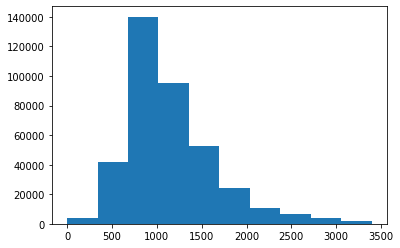

In [ ]:
prices_list = housing.where('price<3395.0').select('price').collect()
price_data = np.array([int(row.price) for row in prices_list])
plt.hist(price_data, bins = 10)

On ne peut pas représenter toutes les valeurs car certaines sont beaucoup trop grandes.
Ces valeurs trop grandes, qui ont un nombre d'occurence negligeable,permettent d'expliquer la raison de l'écart type énorme constaté précedemment.

Comme cette distribution n'est pas une distribution normale, nous nous intéressons aux centiles. Les outliers seront ainsi les prix inférieur à 344 et supérieur à 3395.

#### sqfeet

In [ ]:
housing.describe('sqfeet').show()

+-------+------------------+
|summary|            sqfeet|
+-------+------------------+
|  count|            384977|
|   mean| 1059.899565428584|
| stddev|19150.757244214365|
|    min|                 0|
|    max|           8388607|
+-------+------------------+



In [ ]:
sqfeet_null = housing.select('*').filter(col('sqfeet').isNull()).count()
print('Il y a', sqfeet_null, 'tuples avec une surface nulle.')

Il y a 0 tuples avec une surface nulle.


In [ ]:
sqfeet_count = housing.select('sqfeet').groupby('sqfeet').count().alias('count').withColumnRenamed('count', 'res_count').orderBy("sqfeet")
sqfeet_count.show(10)
sqfeet_count.count()

+------+---------+
|sqfeet|res_count|
+------+---------+
|     0|       48|
|     1|      171|
|     2|       27|
|     3|        1|
|     5|        4|
|     6|        4|
|     7|        4|
|     8|        3|
|     9|        1|
|    10|       10|
+------+---------+
only showing top 10 rows



3277

In [ ]:
sqfeet_count.select('*').orderBy(col('sqfeet').desc()).show()

+-------+---------+
| sqfeet|res_count|
+-------+---------+
|8388607|        1|
|8000000|        1|
|1019856|        2|
| 999999|        4|
| 775814|        1|
| 174240|        1|
|  99204|        1|
|  99202|        1|
|  95242|        1|
|  95209|        1|
|  92037|        1|
|  77006|        1|
|  72916|        1|
|  63134|        1|
|  51206|        1|
|  50000|        5|
|  48207|        1|
|  46561|        1|
|  46514|        1|
|  46205|        1|
+-------+---------+
only showing top 20 rows



In [ ]:
outliers_autres(housing.select('sqfeet'))

bounds :  {'sqfeet': {'q01': 340.0, 'q99': 2405.0}}


DataFrame[sqfeet: int, sqfeet_out: int]

99% des valeurs de sqfeetsont inférieurs à 2405. 

Les outliers seront donc les surfaces inférieur à 340 et supérieurs à 2405.

(array([  1529.,  11490.,  69310., 123365., 103936.,  41299.,  16332.,
          7237.,   4042.,   2585.]),
 array([   0. ,  240.4,  480.8,  721.2,  961.6, 1202. , 1442.4, 1682.8,
        1923.2, 2163.6, 2404. ]),
 <a list of 10 Patch objects>)

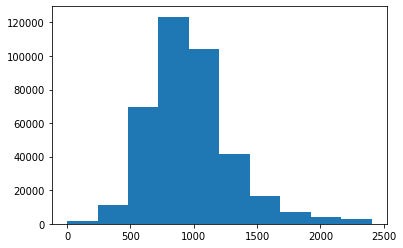

In [ ]:
sqfeet_list = housing.where('sqfeet<2405.0').select('sqfeet').collect()
sqfeet_data = np.array([int(row.sqfeet) for row in sqfeet_list])
plt.hist(sqfeet_data, bins = 10)

Nous remarquons que l'écart type pour sqfeet est aussi très grand par rapport à sa moyenne. Il y a des appartements avec de très grandes surfaces mais en petit nombre ( 15% d'appartements ont un sqfeet \in [ 1150, 8,39 m] ). Ceci est cohérent avec l'observation faite sur les prix. Nous pourrions donc en déduire que la colonne sqfeet est très importante pour la prédiction des prix

#### latitude

In [ ]:
housing.describe('lat').show()

+-------+-----------------+
|summary|              lat|
+-------+-----------------+
|  count|           383059|
|   mean|37.23348675754795|
| stddev|5.546171140040916|
|    min|         -43.5333|
|    max|          102.036|
+-------+-----------------+



In [ ]:
lat_count = housing.select('lat').groupby('lat').count().alias('count').withColumnRenamed('count', 'res_count')
lat_count.show()

+------------------+---------+
|               lat|res_count|
+------------------+---------+
|           39.5026|        3|
|           39.6185|       10|
|           39.5393|      167|
|           39.6412|        6|
|           39.5268|       33|
|           39.5094|        1|
|           39.5466|        1|
|           39.5643|       20|
|           39.5263|       24|
|           39.3826|        5|
|           39.6365|        5|
|             39.59|        1|
|39.525999999999996|        5|
|           39.5433|        1|
|           34.4268|        2|
|           39.6184|       11|
|           39.2637|        2|
|           39.2025|        5|
|           39.3385|       82|
|           34.4197|       18|
+------------------+---------+
only showing top 20 rows



In [ ]:
lat_count = housing.select('lat').groupby('lat').count().alias('count').withColumnRenamed('count', 'res_count').withColumn("pourcentage",pourcentage("res_count")).orderBy(col('res_count').desc())
lat_count.show()

+-------+---------+-----------+
|    lat|res_count|pourcentage|
+-------+---------+-----------+
|   null|     1918|  0.4982116|
|29.8754|     1325|  0.3441764|
|32.4779|      780| 0.20260951|
|39.4242|      757| 0.19663513|
|35.1653|      679| 0.17637417|
|30.3659|      628| 0.16312663|
|32.1149|      603| 0.15663274|
|46.8394|      596| 0.15481444|
|36.9745|      595|  0.1545547|
|33.3755|      588|  0.1527364|
|36.0036|      560| 0.14546323|
|31.5789|      532| 0.13819008|
|30.2007|      532| 0.13819008|
|38.4586|      529|  0.1374108|
|33.7377|      518| 0.13455349|
|32.3055|      515| 0.13377422|
|39.0119|      511| 0.13273521|
|33.9761|      502|  0.1303974|
|27.2889|      491| 0.12754008|
|31.8552|      483| 0.12546204|
+-------+---------+-----------+
only showing top 20 rows



#### longitude

In [ ]:
housing.describe('long').show()

+-------+------------------+
|summary|              long|
+-------+------------------+
|  count|            383059|
|   mean|-92.70063093006361|
| stddev|16.531980066424797|
|    min|          -163.894|
|    max|172.63299999999998|
+-------+------------------+



In [ ]:
long_count = housing.select('long').groupby('long').count().alias('count').withColumnRenamed('count', 'res_count').orderBy(col('res_count').desc())
long_count.show()

+-------------------+---------+
|               long|res_count|
+-------------------+---------+
|               null|     1918|
|           -97.9404|     1313|
|            -84.898|      779|
|           -77.4597|      742|
|           -101.884|      656|
|           -90.2309|      638|
|           -86.2458|      629|
|            -81.252|      603|
|-100.78399999999999|      602|
|           -86.4199|      595|
|           -86.8045|      584|
|           -80.0036|      560|
|           -77.4306|      529|
|           -85.8136|      528|
|           -78.9787|      518|
|           -84.2118|      513|
|           -95.7151|      511|
|            -80.298|      491|
|           -106.435|      483|
|           -104.704|      472|
+-------------------+---------+
only showing top 20 rows



In [ ]:
housing.where(col("long").isNull() & col('lat').isNull()).count()

1918

On peut remarquer que les valeurs de lat et long sont nulles pour les mêmes tuples : 1918 étant négligeable par rapport au nombre total de tuple, nous pourrons envisager de les supprimer lors de la deuxième stratégie.

### Les liens et la description


In [ ]:
housing.select('id').distinct().count()

384977

In [ ]:
housing.select('url').distinct().count()

384977

On remarque qu'il y a autant d'url que de tuples, ainsi l'attribut url n'est pas pertinent, il ne permet pas de différencier des tuples, tout comme l'attribut id.

In [ ]:
housing.select('region_url').distinct().count()

413

Ne donne pas plus d'information que la colonne region.

De plus, nous ne considérons pas les colonnes image_url et descriptions car son information est complexe et nécessite un traitement pour en extraire l'information pertinente (image et texte).


## Régression par arbres de décision

Maintenant que nous avons analyser nos données, nous allons essayer de prédire le prix d'une maison aux Etats-Unis en fonction de certains attributs.

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressionModel
from  pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

### Baseline

Nous avons besoin de référence simple pour savoir si notre modèle apprend bien, autrement dit, si les résultats obtenus sont bons. Pour cela, nous allons comparer notre modèle à la baseline suivante :
- les colonnes id, url, region_url et descriptions ne sont pas prises en compte
- les null sont gardés 

In [ ]:
#Les features qui sont des chaines de caractères
features_str = ['region', 'type', 'laundry_options', 'parking_options', 'state']

#Les noms des features de type String après leur transformations 
prefix = "indexed_"
features_col_indexed = list(map(lambda c:prefix+c, features_str))

#Indexation des valeurs des attributs de features_str
#les null sont gardés
string_indexer = StringIndexer(inputCols=features_str, outputCols=features_col_indexed, handleInvalid='keep')

#Le nom des colonnes indéxées ainsi que les autres features
cols = ['indexed_region',
        'indexed_type',
        'sqfeet', 'beds', 'baths', 'cats_allowed',
        'dogs_allowed', 'smoking_allowed', 'wheelchair_access',
        'electric_vehicle_charge','comes_furnished',
        'indexed_laundry_options',
        'indexed_parking_options',
        'lat', 'long',
        'indexed_state']

#Concatenation des valeurs dans un vecteur
vec_assembler = VectorAssembler(inputCols= cols, outputCol= 'vector', handleInvalid = "keep")

#Discrinination des valeurs continues et catégorielles et indexation de celles-ci 
vec_indexer = VectorIndexer(maxCategories=404, inputCol='vector',outputCol='features', handleInvalid='keep')

In [ ]:
#Définition de la pipeline
stages = [string_indexer, vec_assembler, vec_indexer]
pipeline = Pipeline(stages = stages)

#Application de la pipeline
data = pipeline.fit(housing).transform(housing)
data.select("features", "price").orderBy('price').show()

+--------------------+-----+
|            features|price|
+--------------------+-----+
|[19.0,0.0,650.0,1...|    0|
|[19.0,0.0,650.0,1...|    0|
|[330.0,0.0,954.0,...|    0|
|[19.0,0.0,650.0,1...|    0|
|[71.0,0.0,850.0,1...|    0|
|[71.0,0.0,850.0,1...|    0|
|[71.0,0.0,706.0,1...|    0|
|(16,[0,2,3,4,7,11...|    0|
|(16,[0,2,3,4,7,11...|    0|
|(16,[0,2,3,4,7,11...|    0|
|[19.0,0.0,650.0,1...|    0|
|[71.0,0.0,1007.0,...|    0|
|[19.0,0.0,650.0,1...|    0|
|(16,[0,2,3,4,7,11...|    0|
|[19.0,0.0,650.0,1...|    0|
|[71.0,0.0,1152.0,...|    0|
|[19.0,0.0,650.0,1...|    0|
|[71.0,0.0,850.0,1...|    0|
|[19.0,0.0,1.0,1.0...|    0|
|[71.0,0.0,706.0,1...|    0|
+--------------------+-----+
only showing top 20 rows



### D'autres modèles

Nous allons maintenant essayer d'améliorer notre baseline.

#### Pré-traitements

##### Les valeurs nulles

Les attributs qui possèdent des valeurs nulles sont : 
- laundry_options (20,5%)
- parking_options (36,5%)
- lat (0,5%)
- long (0,5%)

(Sachant que les 0,5% de lat et long représentent les mêmes tuples)

Il est raisonnable de retirer les tuples dont la longitude et la latitude sont nulles et ne pas conserver les colonnes laundry_options et parking_options.

In [ ]:
housing_prep = housing.select(
 'region',
 'price',
 'type',
 'sqfeet',
 'beds',
 'baths',
 'cats_allowed',
 'dogs_allowed',
 'smoking_allowed',
 'wheelchair_access',
 'electric_vehicle_charge',
 'comes_furnished',
 'lat',
 'long',
 'state').where(col('lat').isNotNull() & col('long').isNotNull())

In [ ]:
housing_prep.count()

383059

In [ ]:
tuples_null = housing_prep.dropna().count()
tuples_null

383059

Notre base de données ne contient plus de valeurs nulles.

##### Les valeurs aberrantes

Dans cette partie, nous allons nous intéresser aux valeurs aberrantes des attributs beds, baths, price et sqfeet.

Par ailleurs, ne pensons pas que la notion de outliers a du sens pour des coordonnées GPS (lat et long).

Nous ne nous intéressons pas aux autres attributs car les valeurs sont de types booléennes ou catégorielles.

Comme dit précédemment :    
- beds : outliers si inférieur à 8  
- baths : outliers si inférieur à 1 et supérieur à 3
- price : outliers si inférieur à 344 et supérieur à 3395
- sqfeet : outliers si inférieur à 340 et supérieur à 2405

In [ ]:
housing_prep = housing_prep.select('*').where('beds<=8')
housing_prep.count()

383055

In [ ]:
housing_prep = housing_prep.filter(col("baths").between(1,3))
housing_prep.count()

377034

In [ ]:
housing_prep = housing_prep.filter(col("price").between(344,3395))
housing_prep.count()

369936

In [ ]:
housing_prep = housing_prep.select('*').filter(col('sqfeet').between(340, 2405))
housing_prep.count()

364446

##### Encodage des données

In [ ]:
#Les features qui sont des chaines de caractères
features_str = ['region', 'type', 'state']

#Les noms des features de type String après leur transformations 
prefix = "indexed_"
features_col_indexed = list(map(lambda c:prefix+c, features_str))

#Indexation des valeurs des attributs de features_str
#les null sont gardés
string_indexer = StringIndexer(inputCols=features_str, outputCols=features_col_indexed, handleInvalid='keep')

#Le nom des colonnes indéxées ainsi que les autres features
cols = ['indexed_region',
        'indexed_type',
        'sqfeet', 'beds', 'baths', 'cats_allowed',
        'dogs_allowed', 'smoking_allowed', 'wheelchair_access',
        'electric_vehicle_charge','comes_furnished',
        'lat', 'long',
        'indexed_state']

#Concatenation des valeurs dans un vecteur
vec_assembler = VectorAssembler(inputCols= cols, outputCol= 'vector', handleInvalid = "keep")

#Discrinination des valeurs continues et catégorielles et indexation de celles-ci 
vec_indexer = VectorIndexer(maxCategories=404, inputCol='vector',outputCol='features', handleInvalid='keep')

#Définition de la pipeline
stages = [string_indexer, vec_assembler, vec_indexer]
pipeline = Pipeline(stages = stages)

#Application de la pipeline
data_prep = pipeline.fit(housing_prep).transform(housing_prep)
data_prep.select("features", "price").orderBy('price').show()

+--------------------+-----+
|            features|price|
+--------------------+-----+
|(14,[0,1,2,4,7,11...|  344|
|[3.0,1.0,1266.0,3...|  344|
|(14,[0,2,3,4,10,1...|  344|
|[3.0,1.0,1266.0,3...|  344|
|(14,[0,1,2,4,7,11...|  344|
|(14,[0,2,3,4,11,1...|  345|
|(14,[0,2,3,4,11,1...|  345|
|(14,[0,2,3,4,11,1...|  345|
|(14,[0,1,2,3,4,11...|  345|
|(14,[0,2,3,4,11,1...|  345|
|[3.0,5.0,500.0,2....|  345|
|[128.0,1.0,2000.0...|  345|
|(14,[0,2,3,4,11,1...|  345|
|[266.0,0.0,1072.0...|  345|
|(14,[0,2,3,4,7,11...|  345|
|[32.0,0.0,1526.0,...|  346|
|(14,[0,2,4,7,11,1...|  348|
|(14,[0,2,3,4,7,11...|  349|
|(14,[0,2,3,4,7,11...|  349|
|(14,[0,2,3,4,7,11...|  349|
+--------------------+-----+
only showing top 20 rows



##### Selection d'attributs

PCA (Analyse en composantes principales) est un algorithme statistique qui permet de trouver un sous-espace vectoriel de nos données tout en minimisant la perte d'information, autrement dit, PCA permet de réduire la dimension de nos données tout en gardant le maximun d'information.

Nous allons utiliser PCA pour trouver les attributs les plus importants pour prédire le prix.

In [ ]:
from pyspark.ml.feature import PCA

In [ ]:
pca = PCA(k=10, inputCol='features')
model_pca = pca.fit(data_prep)

In [ ]:
model_pca.explainedVariance

DenseVector([0.942, 0.0537, 0.0026, 0.0014, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.0])

On peut observer que 5 variables possèdent 100% de l'information. On va alors à nouveau appliquer PCA avec k=5 pour récupérer les features.

In [ ]:
pca = PCA(k=5, inputCol='features')
pca.setOutputCol('pca_output')
model_pca = pca.fit(data_prep).transform(data_prep)
features_pca = model_pca.select('pca_output', 'price')
features_pca.show()

+--------------------+-----+
|          pca_output|price|
+--------------------+-----+
|[-1077.8972601614...| 1148|
|[-1000.9076406175...| 1200|
|[-1682.8170943371...| 1813|
|[-707.93672622707...| 1095|
|[-719.93515319749...| 1093|
|[-660.94272382000...|  935|
|[-707.93672622707...| 1095|
|[-1052.8990107304...| 1525|
|[-929.91641252616...| 1295|
|[-719.93531039874...| 1086|
|[-1180.8835702733...| 1159|
|[-765.92937784379...| 1349|
|[-763.92972645954...| 1449|
|[-950.91173020467...| 1295|
|[-918.91585012208...|  982|
|[-1192.8804102887...| 1895|
|[-1191.8807111683...| 1495|
|[-1599.8308799885...| 1899|
|[-889.91963191249...| 1075|
|[-1449.8468018365...| 1495|
+--------------------+-----+
only showing top 20 rows



### Evaluation des modèles

#### La loss et gridSearch

La loss utilisé est la rmse.

In [ ]:
rmse_evaluator = RegressionEvaluator(predictionCol="prediction",
                 labelCol="price",metricName="rmse")

Nous allons faire varier deux paramètres dans notre gridSearch :    
- la profondeur maximale de l'arbre
- le nombre d'instance minimale par noeud

In [ ]:
#Création de l'arbre de décision pour la régression
dt = DecisionTreeRegressor(featuresCol='features', labelCol='price', predictionCol='prediction', maxBins=404)

#Les paramètres
dt_paramGrid = ParamGridBuilder()\
.addGrid(dt.maxDepth, [3,4,5,6,7,8])\
.addGrid(dt.minInstancesPerNode, [5, 10, 20, 30]) \
.build()

cv = CrossValidator(estimator=dt, \
estimatorParamMaps=dt_paramGrid, \
evaluator=rmse_evaluator, \
numFolds=5, \
parallelism=2)


#### Sans pré-traitements (baseline)

In [ ]:
#Les données sont data
res = cv.fit(data)

In [ ]:
params = [{p.name: v for p, v in m.items()} for m in res.getEstimatorParamMaps()]
pd.DataFrame.from_dict([
    {res.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, res.avgMetrics)
])

,rmse,maxDepth,minInstancesPerNode
0,2.571830e+06,3,5
1,2.571755e+06,3,10
2,2.571711e+06,3,20
3,2.571705e+06,3,30
4,3.215612e+06,4,5
5,2.914369e+06,4,10
6,2.717427e+06,4,20
7,2.571767e+06,4,30
8,3.215624e+06,5,5
9,2.914440e+06,5,10


In [ ]:
res.bestModel

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_4cd2db001e96, depth=3, numNodes=13, numFeatures=16

In [ ]:
train, test = data.randomSplit([0.7, 0.3])
dt = DecisionTreeRegressor(featuresCol='features', labelCol='price', predictionCol='prediction', maxBins=404, maxDepth=3)
model = dt.fit(train)
predict = model.transform(test)
rmse_evaluator.evaluate(predict)

784362.6832004734

#### Avec les pré-traitements

In [ ]:
#Les données sont data_prep
res_prep = cv.fit(data_prep)

In [ ]:
params = [{p.name: v for p, v in m.items()} for m in res_prep.getEstimatorParamMaps()]

pd.DataFrame.from_dict([
    {res_prep.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, res_prep.avgMetrics)
])

,rmse,maxDepth,minInstancesPerNode
0,312.939692,3,5
1,312.939692,3,10
2,312.939692,3,20
3,312.939692,3,30
4,298.685821,4,5
5,298.685821,4,10
6,298.685821,4,20
7,298.685821,4,30
8,287.706647,5,5
9,287.706647,5,10


On remarque que les résultats sont bien meilleurs, on divise la rmse par 10 000. 

Dans la partie suivante, nous regarderons si les résultats sont encore meilleurs grâce à PCA. 

In [ ]:
res_prep.bestModel

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_4cd2db001e96, depth=8, numNodes=505, numFeatures=14

In [ ]:
train_prep, test_prep = data_prep.randomSplit([0.7, 0.3])
dt_prep = DecisionTreeRegressor(featuresCol='features', labelCol='price', predictionCol='prediction', maxBins=404, maxDepth=8)
model_prep = dt_prep.fit(train_prep)
predict_prep = model_prep.transform(test_prep)

In [ ]:
rmse_evaluator.evaluate(predict_prep)

263.2065443202104

On remarque que le meilleur modèle est avec la profondeur la plus grande, on peut alors se demander, si en augmentant encore la profondeur notre modèle sera meilleure ou s'il sur-apprendra. 
Testons alors sur des valeurs maxDepth plus grandes : 

In [ ]:
########## AUTRE GRID SEARCH EN AUGMENTANT LA DEPTH ############
dt_paramGrid = ParamGridBuilder()\
.addGrid(dt.maxDepth, [9,11,13,15,17])\
.addGrid(dt.minInstancesPerNode, [5, 10, 20, 30]) \
.build()

cv = CrossValidator(estimator=dt, \
estimatorParamMaps=dt_paramGrid, \
evaluator=rmse_evaluator, \
numFolds=5, \
parallelism=2)

In [ ]:
res_prep2 = cv.fit(data_prep)

In [ ]:
params = [{p.name: v for p, v in m.items()} for m in res_prep2.getEstimatorParamMaps()]

pd.DataFrame.from_dict([
    {res_prep2.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, res_prep2.avgMetrics)
])

,rmse,maxDepth,minInstancesPerNode
0,254.272806,9,5
1,254.265091,9,10
2,254.451768,9,20
3,254.988525,9,30
4,239.725762,11,5
5,239.671180,11,10
6,240.573561,11,20
7,241.814077,11,30
8,227.877839,13,5
9,227.240321,13,10


In [ ]:
res_prep2.bestModel

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_8b0f8a938feb, depth=17, numNodes=22501, numFeatures=14

Nous aboutissons à la même conclusion que précédement. Nous allons continuer d'explorer un peu plus l'espace des hyperparamètres en augmentant maxDepth.
On peut par ailleurs, remarquer que les meilleurs score ont minInstancePerNode=10.


In [ ]:
dt_prep = DecisionTreeRegressor(featuresCol='features', labelCol='price', predictionCol='prediction', maxBins=404, maxDepth=17, minInstancesPerNode=10 )
model_prep = dt_prep.fit(train_prep)
predict_prep = model_prep.transform(test_prep)

In [ ]:
rmse_evaluator.evaluate(predict_prep)

212.81194628630064

In [ ]:
########## AUTRE GRID SEARCH EN AUGMENTANT LA DEPTH ############
dt_paramGrid = ParamGridBuilder()\
.addGrid(dt.maxDepth, [19,21,23,25,27])\
.addGrid(dt.minInstancesPerNode, [10]) \
.build()

cv = CrossValidator(estimator=dt, \
estimatorParamMaps=dt_paramGrid, \
evaluator=rmse_evaluator, \
numFolds=5, \
parallelism=2)

In [ ]:
res_prep4 = cv.fit(data_prep)

In [ ]:
params = [{p.name: v for p, v in m.items()} for m in res_prep4.getEstimatorParamMaps()]

pd.DataFrame.from_dict([
    {res_prep4.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, res_prep4.avgMetrics)
])

,rmse,maxDepth,minInstancesPerNode
0,208.936199,19,10
1,207.091703,21,10
2,206.304677,23,10
3,206.005109,25,10
4,205.938871,27,10


En effet, on obtient à nouveau une meilleure rmse.

Pour aller plus loin, on pourrait chercher à partir de quand le modèle sur-apprend.

#### Avec les attributs de PCA

In [ ]:
#On redéfinie DecisionTreeRegressor car le nom des colonnes des features est différentes
dt_pca = DecisionTreeRegressor(featuresCol='pca_output', labelCol='price', predictionCol='prediction', maxBins=404)

In [ ]:
#On redéfinie le CrossValidator pour y mettre dt_pca comme estimator
cv_pca = CrossValidator(estimator=dt_pca, \
estimatorParamMaps=dt_paramGrid, \
evaluator=rmse_evaluator, \
numFolds=5, \
parallelism=2)

In [ ]:
#On applique la cross-valisation sur features_pca (c'est features sélectionnées par pca)
res_pca = cv_pca.fit(features_pca)

In [ ]:
res_pca.bestModel

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_dec4de9f0852, depth=5, numNodes=63, numFeatures=5

In [ ]:
params = [{p.name: v for p, v in m.items()} for m in res_pca.getEstimatorParamMaps()]

pd.DataFrame.from_dict([
    {res_pca.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, res_pca.avgMetrics)
])

,rmse,maxDepth,minInstancesPerNode
0,352.912349,3,5
1,352.912349,3,10
2,352.912349,3,20
3,352.912349,3,30
4,352.912349,4,5
5,352.912349,4,10
6,352.912349,4,20
7,352.912349,4,30
8,352.912349,5,5
9,352.912349,5,10


In [ ]:
train_pca, test_pca = features_pca.randomSplit([0.7, 0.3])
dt_pca = DecisionTreeRegressor(featuresCol='pca_output', labelCol='price', predictionCol='prediction', maxBins=404, maxDepth=5)
model_pca = dt_pca.fit(train_pca)
predict_pca = model_pca.transform(test_pca)

In [ ]:
rmse_evaluator.evaluate(predict_pca)

351.56743218515163

On remarque que les scores sont moins bons que sans la sélection poussée d'attribut.

### Conclusion et ouverture


Les meilleurs résultats sont obtenus en :     
- supprimant les valeurs nulles de longitude et latitude
- supprimant les colonnes id, url, region_url, image_url, parking_options et laundry_options
- une profondeur de 27 pour l'arbre de décision et le minimum d'instance par noeud à 10.

Pour aller plus loin, on pourrait essayer de  : 
- normaliser les données 
- sélectionner moins de features
- faire de plus grand gridSearch avec plus de d'hyperparamètres
- essayer d'autres métriques...

##END